Version 2.0.0 of SWTLoc was a major release, consisting of the following major changes

- Addition of new engine for Stroke Width Transform - `numba`, which gives more than 10x speed increase
- Addition of `saveCrops` function
- Re-Organisation of codebase to use Abstractions such as classes for
    - Letter : Class representing a Letter
    - Word : Class representing a Word
    - SWTImage : Class representing an SWT Image
- Consolidation of various localisation methods for ``Letter`` and ``Word`` objects
- Accessing intermediary stage images using Image Codes

# Imports

In [2]:
# Check version runing on Jupyter notebook
from platform import python_version
import sys

print('Python Version : ', python_version())
print('Python Path : ', sys.executable)

Python Version :  3.6.13
Python Path :  D:\Personal Stuff\swtloc-project\venvs\py36VenvDev\python.exe


In [1]:
import sys
sys.path.append('../')

In [127]:
%load_ext autoreload
%autoreload 2
from swtloc import SWTLocalizer
from swtloc._utils import imgshowN
from swtloc.configs import get_code_descriptions, CODE_NAME_VAR_MAPPINGS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import os
import pandas as pd
import numpy as np
from IPython.display import clear_output

# Path and Variable Initialisations

In [86]:
rawimage_path = 'images/'

In [121]:
img_paths = []
res_path = []
img_names = []
img_text_modes = ['db_lf', 'lb_df', 'db_lf', 'lb_df', 'db_lf', 'db_lf']
for each_testfolder in [k for k in os.listdir(rawimage_path) if 'test_image' in k]:
    # Directories
    test_folder_path = rawimage_path+each_testfolder+'/'
    _respath = test_folder_path+'imp_results/'
    res_path.append(_respath)
    os.makedirs(_respath, exist_ok=True)
    
    image_name = [k for k in os.listdir(test_folder_path) if any([ext in k for ext in ['jpg', 'jpeg', 'png']])][0]
    img_names.append(image_name)
    image_path = test_folder_path+image_name
    img_paths.append(image_path)


In [122]:
swtl = SWTLocalizer(image_paths=img_paths)
print(swtl.swtimages)

[SWTImage-test_img1, SWTImage-test_img2, SWTImage-test_img3, SWTImage-test_img4, SWTImage-test_img5, SWTImage-test_img6]


# Speed Benchmarking

From v2.0.0 onwards, there were changes made to the core algorithm implementations of finding stroke widths. A new engine `numba` was added as a parameter to the `SWTImage.transformImage` which shows (initial testing) nearly 50x speed improvement over the vanilla python implementation of the algorithm. Below code block performs benchmarking for the above statement


In [97]:
_cols = ['Python(SWTLoc v1.1.1)', 'Python(SWTLoc v2.0.0)', 'numba(SWTLoc v2.0.0)']
timedf = pd.DataFrame(index=img_names, columns=_cols)

for img_name, each_img_path, _text_mode in zip(img_names, img_paths, img_text_modes):
    
    swtl =SWTLocalizer(image_paths=each_img_path)
    swtlImgObj = swtl.swtimages[0]
    _t1 = []
    _t2 = []
    _t3 = []
    
    # Python - Old version timing
    for _ in range(10):
        swtl.swttransform(imgpaths=each_img_path, text_mode=_text_mode)
        _t1.append(float(swtl.transform_time.split(' ')[0]))
    
    imgshowN([swtl.orig_img, swtl.swt_mat, swtl.swtlabelled_pruned13C],
         ['Original Image', 'Stroke Width Transform', 'Connected Components'])
    timedf.loc[img_name, _cols[0]] = np.mean(_t1)

    # Python - New version timing
    for _ in range(10):
        swtlImgObj.transformImage(text_mode=_text_mode, engine='python', display=False)
        _t2.append(float(swtlImgObj.transform_time.split(' ')[0]))

    swtlImgObj.transformImage(text_mode=_text_mode, engine='python', display=True)
    timedf.loc[img_name, _cols[1]] = np.mean(_t2)

    # numba - New version timing
    for _ in range(10):
        swtlImgObj.transformImage(text_mode=_text_mode, display=False)
        _t3.append(float(swtlImgObj.transform_time.split(' ')[0]))

    swtlImgObj.transformImage(text_mode=_text_mode, display=True)
    timedf.loc[img_name, _cols[2]] = np.mean(_t3)
    
    
    clear_output(wait=True)
    # input()

In [94]:
timedf

Python(v1.1.1) Python(v2.0.0) numba(v2.0.0)
test_img1.jpg         15.6135         8.0707        0.3082
test_img2.jpg          9.6445         4.1726        0.1759
test_img3.jpg          4.3864         2.6378        0.0826
test_img4.jpeg         7.2245         3.8874        0.1405
test_img5.jpg         16.3378         7.5922        0.3003
test_img6.jpg          4.8307         2.8728        0.0835

In [193]:
time_comp_df = timedf.copy()

_old_py_timings = time_comp_df[_cols[0]]
_new_py_timings = time_comp_df[_cols[1]]
_new_nb_timings = time_comp_df[_cols[2]]
time_comp_df = time_comp_df.applymap(lambda x: str(round(x, 3))+' seconds')
time_comp_df[_cols[0]+'[x Increase]'] = (_old_py_timings/_old_py_timings).apply(round, args=(3,)).astype(str) + 'x'
time_comp_df[_cols[1]+'[x Increase]'] = (_old_py_timings/_new_py_timings).apply(round, args=(3,)).astype(str) + 'x'
time_comp_df[_cols[2]+'[x Increase]'] = (_old_py_timings/_new_nb_timings).apply(round, args=(3,)).astype(str) + 'x'
time_comp_df = time_comp_df[sorted(time_comp_df.columns)]
time_comp_df.style.set_properties(**{'width': '110px', 'text-align': 'center'})


# Save intermediary stage images via Image Codes

From v2.0.0 onwards, a provision was added to save the intermediary stage images by access the `SWTImage.showImage` function. 

<div class="alert alert-block alert-info">
<b>NOTE:</b> 
<u>SWTImage</u> class procedures are sequential in nature, so for example if Letters havent yet been localized then there will be an error pointing to the fact that a particular function needs to be run before that Image Codes [IMAGE_PRUNED_3C_LETTER_LOCALIZATIONS, IMAGE_ORIGINAL_LETTER_LOCALIZATIONS, IMAGE_ORIGINAL_MASKED_LETTER_LOCALIZATIONS] are made available.
</div>

**Available Image Codes**

In [136]:
image_code_df = pd.DataFrame(columns=['Description'])

for each_code_name, each_code in CODE_NAME_VAR_MAPPINGS.items():
    image_code_df.loc[each_code_name] = get_code_descriptions(each_code).replace('\n', ' ')
image_code_df.style.set_properties(**{'width': '600px', 'text-align': 'center'})


**Transforming Image**

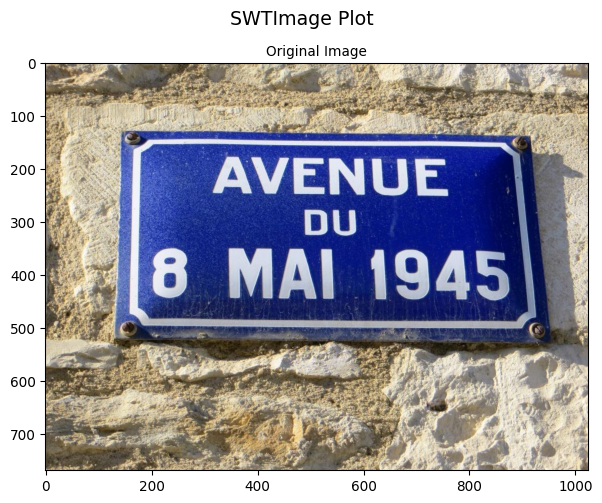

In [152]:
swtImgObj = swtl.swtimages[0]
swtImgObj.showImage()

In [138]:
swt_mat = swtImgObj.transformImage(text_mode='db_lf', maximum_angle_deviation=np.pi/2,
                                   edge_function='ac', gaussian_blurr_kernel=(11, 11),
                                   minimum_stroke_width=5, maximum_stroke_width=50, display=False)
image_cc, pruned_image_cc = swtImgObj.findAndPruneConnectedComponents(display=False)
localized_letters = swtImgObj.localizeLetters(display=False)
localized_words = swtImgObj.localizeWords(display=False)

**Display Multiple Intermediary Stage Images**

In [144]:
# Import the Image Codes from configs
from swtloc.configs import (IMAGE_SWT_TRANSFORMED,
                            IMAGE_CONNECTED_COMPONENTS_3C_WITH_PRUNED_ELEMENTS)

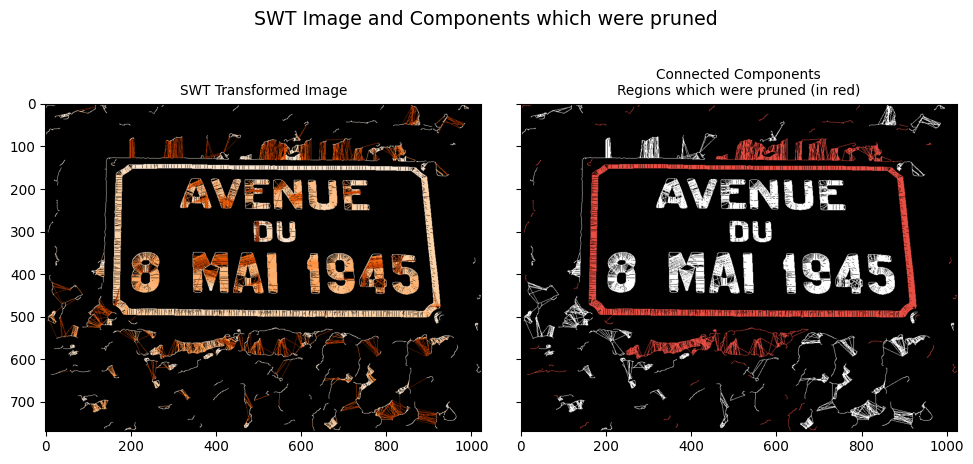

In [145]:
swtImgObj.showImage(image_codes=[IMAGE_SWT_TRANSFORMED, 
                                 IMAGE_CONNECTED_COMPONENTS_3C_WITH_PRUNED_ELEMENTS],
                    plot_title='SWT Image and Components which were pruned')

**Display Single Intermediary Stage Image**

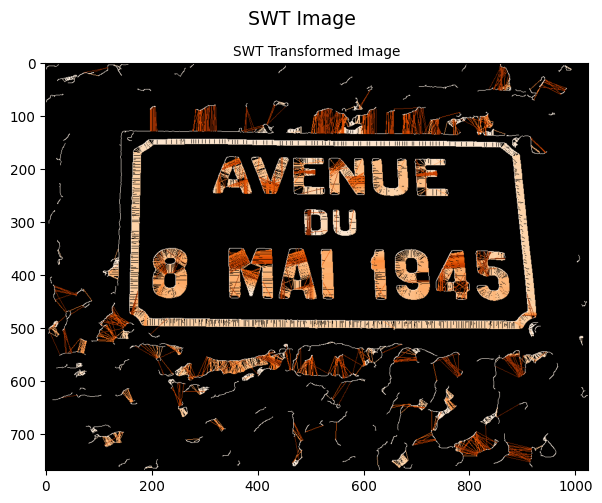

In [146]:
swtImgObj.showImage(image_codes=[IMAGE_SWT_TRANSFORMED],
                    plot_title='SWT Image')

**Save Multiple Intermediary images in a single plot**

In [147]:
swtImgObj.showImage(image_codes=[IMAGE_SWT_TRANSFORMED, 
                                 IMAGE_CONNECTED_COMPONENTS_3C_WITH_PRUNED_ELEMENTS],
                    plot_title='SWT Image and Components which were pruned', 
                    save_fig=True, save_dir=res_path[0])

**Save single Intermediary images in a single plot**

In [148]:
swtImgObj.showImage(image_codes=[IMAGE_SWT_TRANSFORMED],
                    plot_title='SWT Image', 
                    save_fig=True, save_dir=res_path[0])

# Localization annotation for Letters and Words

From v2.0.0 onwards, two classes `Letter` and `Word` were incuclated representing the abstraction for a letter and a word.
There are various methods for the annotation of each localization annotation

For `Letter`'s, the localization annotations available are: 

    - "min_bbox" : Minimum Bounding Box Boundary Localization Annotation
    - "ext_bbox" : External Bounding Box Boundary Localization Annotation
    - "outline" : Contour Boundary Localization Annotation
    
For `Word`'s, the localization annotations available are: 

    - "bubble" : Fused Bubble Boundary Localization Annotation
    - "bbox" : Fused Bounding Box Boundary Localization Annotation
    - "polygon" : Contour Boundary Localization Annotation

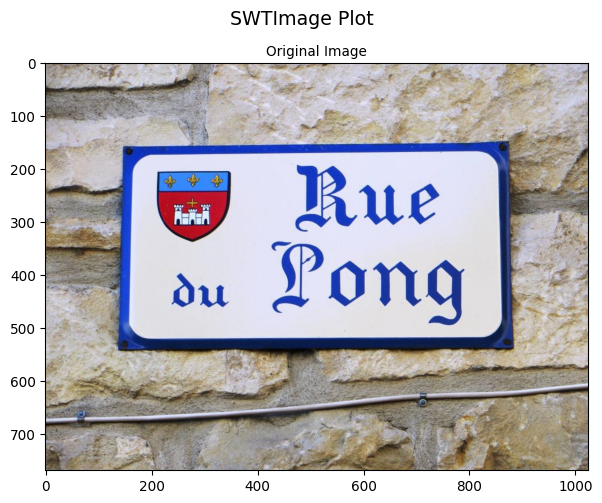

In [153]:
swtImgObj = swtl.swtimages[1]
swtImgObj.showImage()

In [155]:
swt_mat = swtImgObj.transformImage(maximum_angle_deviation=np.pi/2,
                                   edge_function='ac', gaussian_blurr_kernel=(11, 11),
                                   minimum_stroke_width=5, maximum_stroke_width=50, display=False)
image_cc, pruned_image_cc = swtImgObj.findAndPruneConnectedComponents(display=False)

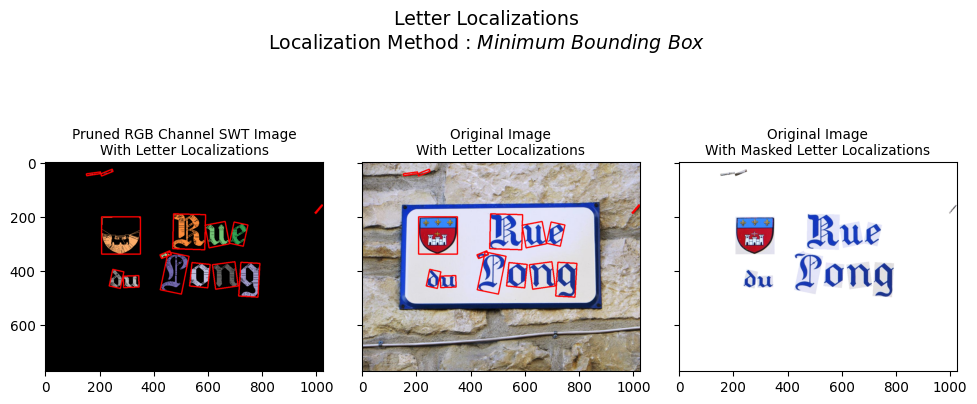

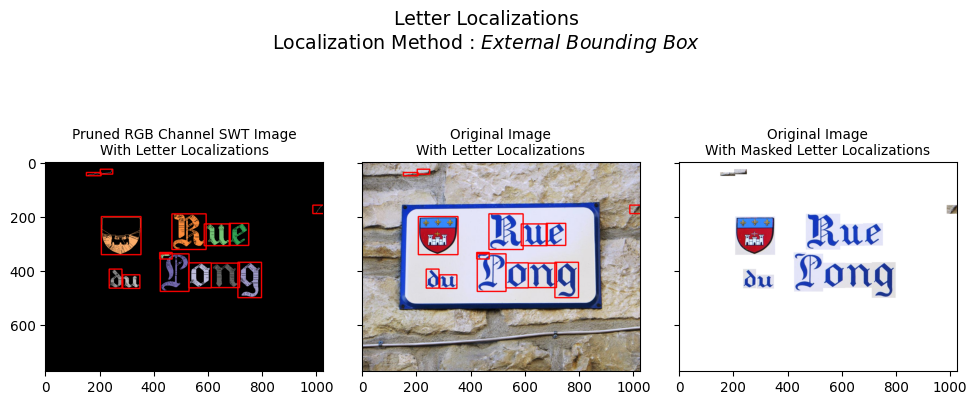

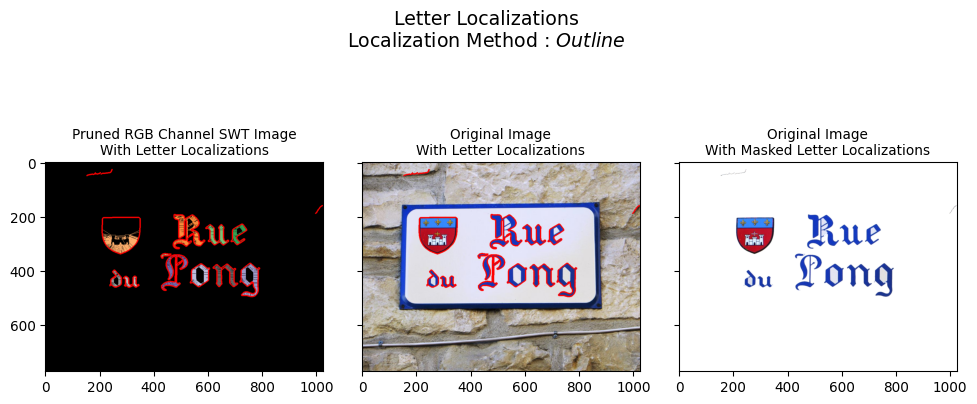

In [157]:
localized_letters = swtImgObj.localizeLetters()
localized_letters = swtImgObj.localizeLetters(localize_by='ext_bbox')
localized_letters = swtImgObj.localizeLetters(localize_by='outline')

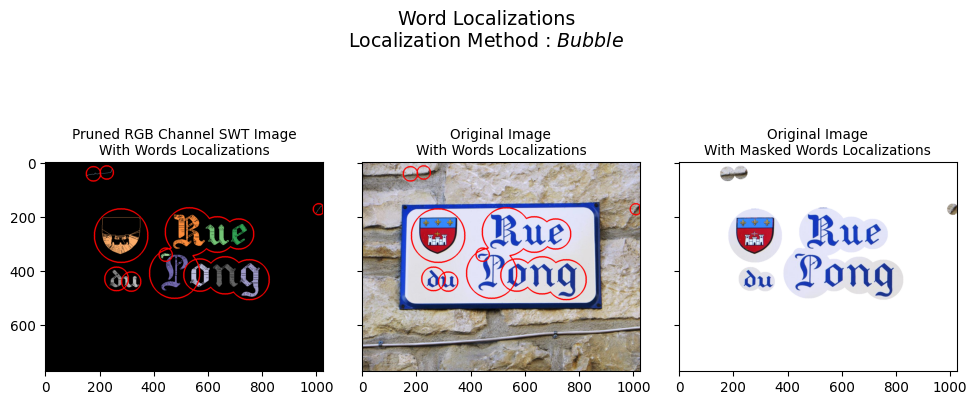

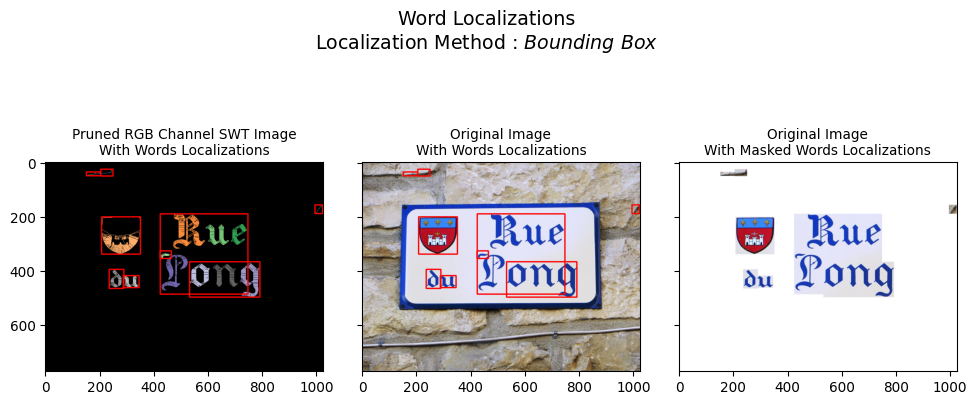

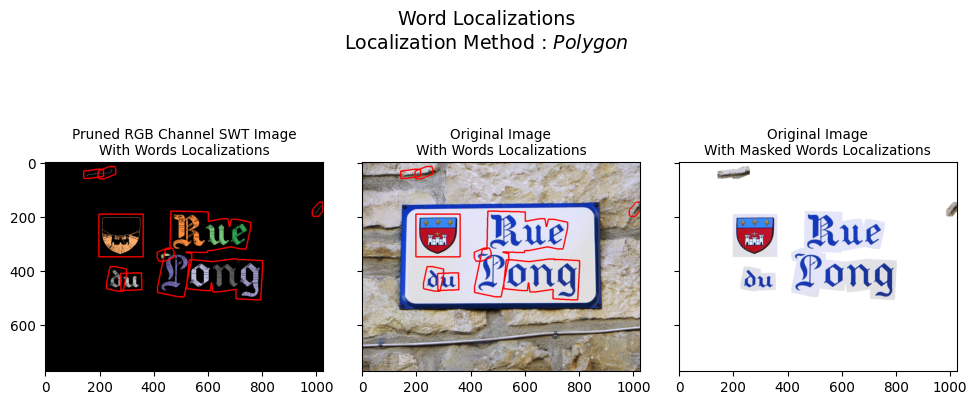

In [158]:
localized_words = swtImgObj.localizeWords()
localized_words = swtImgObj.localizeWords(localize_by='bbox')
localized_words = swtImgObj.localizeWords(localize_by='polygon')

# Generating Crops

From v2.0.0 onwards, provision to save a crop of the `Letter` or a `Word` has been added via the function `SWTImage.saveCrop`. The crops can be made on any one of the available image codes (See [Available Image Codes & Their Meanings](#Save-intermediary-stage-images-via-Image-Codes)) for a particular `letter` or `word` key

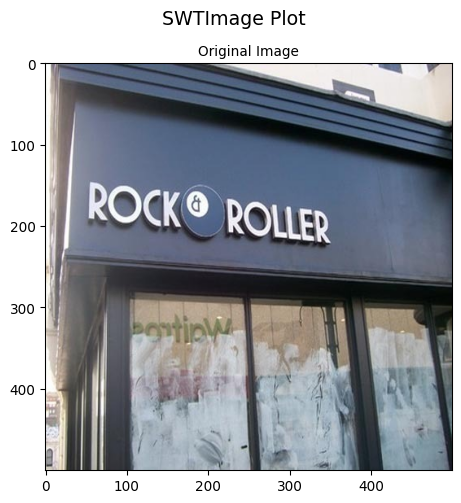

In [159]:
swtImgObj = swtl.swtimages[2]
swtImgObj.showImage()

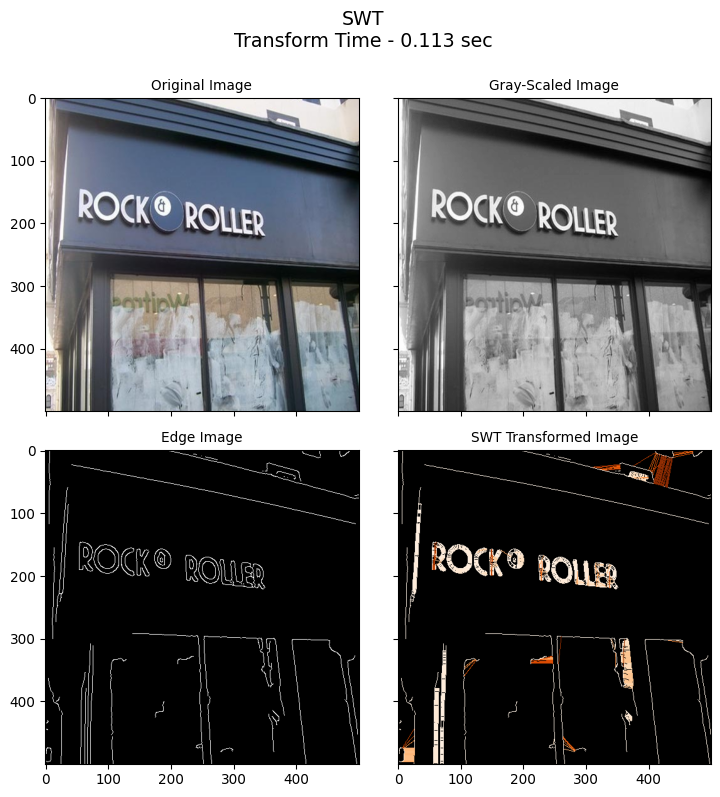

In [163]:
swt_mat = swtImgObj.transformImage(text_mode='db_lf', maximum_angle_deviation=np.pi/2,
                                   edge_function='ac', gaussian_blurr_kernel=(11, 11),
                                   minimum_stroke_width=5, maximum_stroke_width=50, display=True)
image_cc, pruned_image_cc = swtImgObj.findAndPruneConnectedComponents(display=False)
localized_letters = swtImgObj.localizeLetters(display=False)
localized_words = swtImgObj.localizeWords(localize_by='polygon', display=False)

**Saving Crops of Letters**

To assist with visualising letter of interest, whose crop need to be saved, there is a function `SWTImage.getLetter` which visualizes a particular queried letter by its label.

In [164]:
localized_letters

{1: Letter-1,
 2: Letter-2,
 3: Letter-3,
 4: Letter-4,
 5: Letter-5,
 6: Letter-6,
 7: Letter-7,
 8: Letter-8,
 9: Letter-9,
 10: Letter-10,
 11: Letter-11,
 12: Letter-12,
 13: Letter-13,
 14: Letter-14,
 15: Letter-15,
 16: Letter-16,
 17: Letter-17,
 18: Letter-18,
 19: Letter-19}

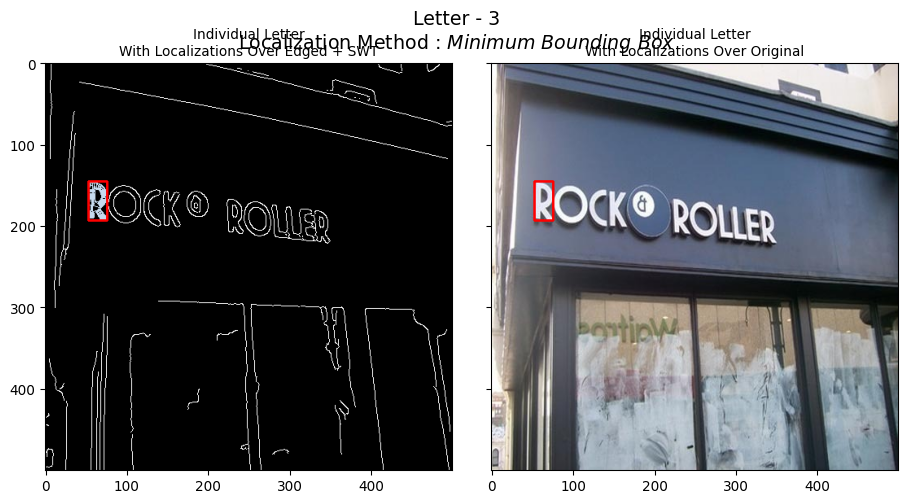

In [168]:
_ = swtImgObj.getLetter(3)

In [181]:
# To save the crop of 3rd letter as shown in the 
from swtloc.configs import (IMAGE_ORIGINAL,
                            IMAGE_SWT_TRANSFORMED)
swtImgObj.saveCrop(save_path=res_path[2], crop_of='letters', crop_key=3,
                   crop_on=IMAGE_SWT_TRANSFORMED, crop_type='min_bbox')
swtImgObj.saveCrop(save_path=res_path[2], crop_of='letters', crop_key=3,
                   crop_on=IMAGE_ORIGINAL, crop_type='min_bbox')

**Saving Crops of Words**


To assist with visualising word of interest, whose crop need to be saved, there is a function `SWTImage.getWord` which visualizes a particular queried word by its label.

In [170]:
localized_words

{1: Word-1,
 2: Word-2,
 3: Word-3,
 4: Word-4,
 5: Word-5,
 6: Word-6,
 7: Word-7,
 8: Word-8,
 9: Word-9,
 10: Word-10,
 11: Word-11,
 12: Word-12,
 13: Word-13}

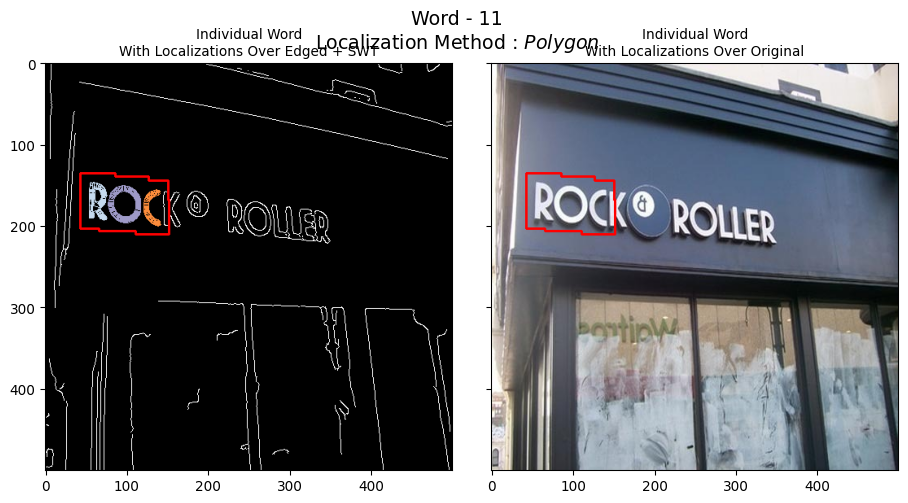

In [179]:
_ = swtImgObj.getWord(11, localize_by='polygon')

In [182]:
# To save the crop of 3rd letter as shown in the 
from swtloc.configs import (IMAGE_ORIGINAL,
                            IMAGE_SWT_TRANSFORMED)
swtImgObj.saveCrop(save_path=res_path[2], crop_of='words', 
                   crop_key=11, crop_on=IMAGE_SWT_TRANSFORMED, crop_type='polygon')
swtImgObj.saveCrop(save_path=res_path[2], crop_of='words', 
                   crop_key=11, crop_on=IMAGE_ORIGINAL, crop_type='polygon')

# Random Testing Space